### Setup

In [20]:
#Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import os
import zipfile
import os
import re


In [21]:
import os
import pandas as pd


df = pd.read_csv("/Users/iphonex/Downloads/Court-Cases-Text-Analytics/Ontario-Court-Cases/data/canlii_final_report_20.csv")
clean_folder = "/Users/iphonex/Downloads/Court-Cases-Text-Analytics/Ontario-Court-Cases/data/data_clean"

# Build a mapping from Source URL in each txt -> text
url_to_text = {}

for fname in os.listdir(clean_folder):
    if fname.endswith(".txt"):
        file_path = os.path.join(clean_folder, fname)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        
        for line in text.splitlines():
            if line.lower().startswith("source url:"):
                url = line.split(":", 1)[1].strip()  
                url_to_text[url] = text
                break

# Align texts with CSV rows using URL

texts = []
missing_urls = []

for url in df['URL']:
    if url in url_to_text:
        texts.append(url_to_text[url])
    else:
        texts.append("")  # missing file
        missing_urls.append(url)


if missing_urls:
    print(f"WARNING: {len(missing_urls)} URLs in CSV do not have a corresponding txt file.")
    for url in missing_urls:
        print("Missing:", url)

print(f"Loaded {len(df)} cases and {len(texts)} texts")



Missing: https://www.canlii.org/en/on/oncj/doc/2025/2025oncj3/2025oncj3.html
Loaded 510 cases and 510 texts


### Sentence-BERT embeddings - Topic Modeling

In [22]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt

In [23]:
#Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, fast for 500+ cases
embeddings = model.encode(texts, show_progress_bar=True)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 825.72it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 16/16 [00:09<00:00,  1.63it/s]


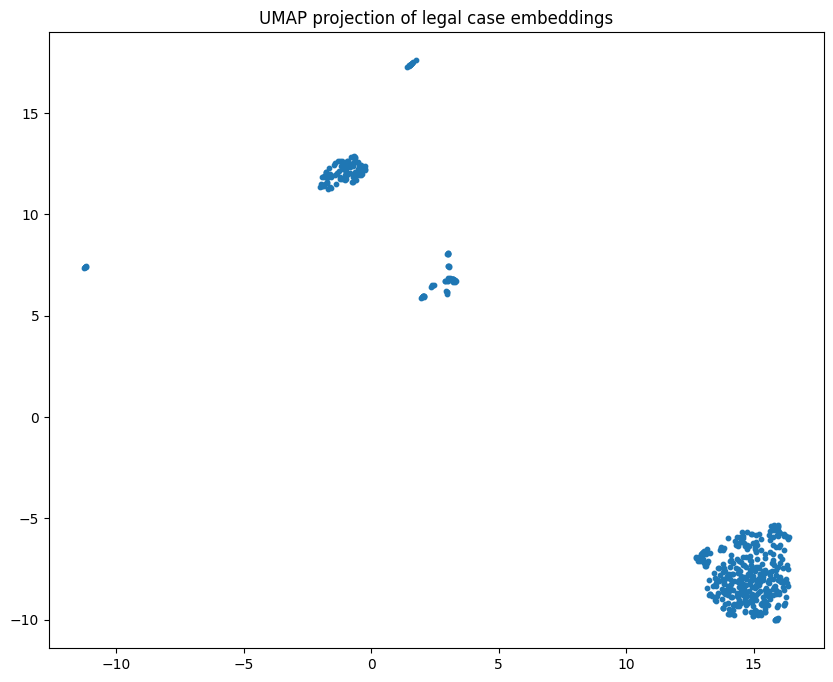

In [24]:
#Dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], s=10)
plt.title("UMAP projection of legal case embeddings")
plt.show()



The BERT sentence embedding approach seperated the cases into 3-4 groups. There is one larger cluster on the right, a medium one, a smaller one and one that seems to relate to outliers. However, since our sample is small to represent all possible criminal offense, we will chose to go with 4 clusters to represent the different cases complexities.

In [25]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(embeddings)

df['Cluster'] = cluster_labels

print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
print(df[['Case_Title', 'Cluster']].head(10))

Number of clusters found: 6
       Case_Title  Cluster
0      R. v. M.T.        4
1      R. v. J.G.        1
2  R. v. Laguerre        4
3     R. v. Khosa        1
4  R. v. Lachance        1
5     R. v. Eagen        1
6   R. v. Burnett        5
7    R. v. Nguyen       -1
8      R. v. P.G.        4
9    R. v. Cheema        1


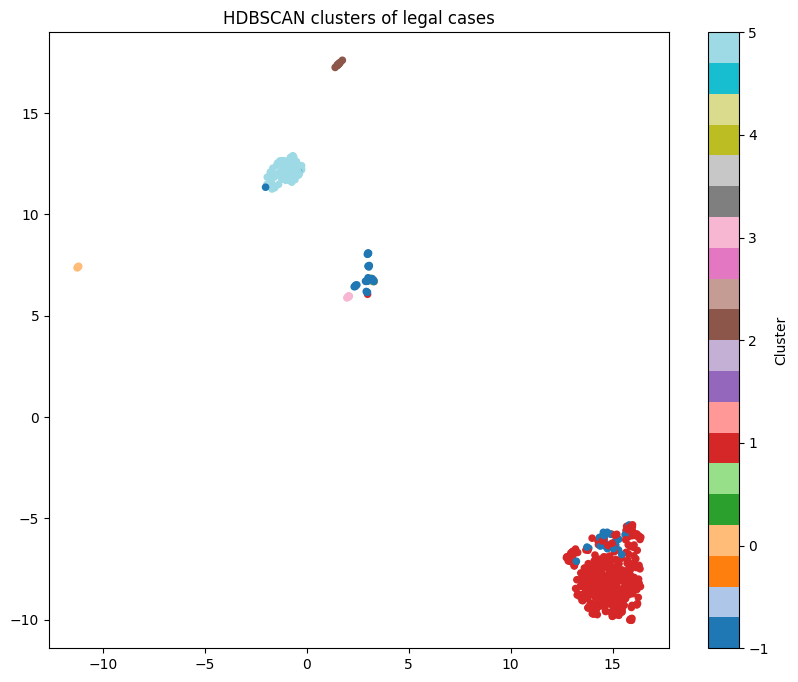

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=cluster_labels, cmap='tab20', s=20)
plt.colorbar(label='Cluster')
plt.title("HDBSCAN clusters of legal cases")
plt.show()

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#Extact the top key words per cluster
def get_top_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Sum TF-IDF scores per term across all documents
    tfidf_sums = X.sum(axis=0).A1
    top_indices = tfidf_sums.argsort()[::-1][:top_n]
    
    return feature_names[top_indices]

# Group texts by cluster
clusters = df['Cluster'].unique()
for cluster in clusters:
    if cluster == -1:
        continue  # -1 is noise in HDBSCAN
    cluster_texts = [text for text, lbl in zip(texts, cluster_labels) if lbl == cluster]
    top_words = get_top_keywords(cluster_texts, top_n=10)
    print(f"Cluster {cluster}: {', '.join(top_words)}")

Cluster 4: complainant, mother, defendant, testified, sex, hair, messages, activity, phone, home
Cluster 1: sentence, offender, ms, defendant, officer, delay, sentencing, applicant, years, firearm
Cluster 5: mr, sentence, offender, complainant, defendant, accused, ms, testified, sentencing, applicant
Cluster 2: sentence, db, ycja, custody, delay, accused, complainant, para, search, probation
Cluster 0: 25, number, file, 998, 23, 04, 00, 03
Cluster 3: ms, sentence, offender, testified, mother, delay, asked, victims, video, party


**Cluster Analysis**:
- Cluster 4 (Sexual Offensses possibly involving minors): 
    * This cluster seems to involve sexual offenses, likely sexual assault cases, potentially involving minors (with words like mother, complainant) or family / household context
    * Evidence often comes from testimony, messages, or phone activity

- Cluster 1 (Violent crimes / firearm offenses): 
    * Keywords like forearm and officer suggest weapon-related iffenses or violent crimes
    * sentence, years, delay -> procedural / sentencimg context, probably serious criminal offenses 

- Cluster 5 (General criminal offenses / mixed cases): 
    * Generic crimial law terms (offender, accused, testified)
    * Seems like general sentencing cases, maybe property crimes or minor assaults

- Cluster 2 (Youth criminal offenses): 
    * YCJA refers to Youth Criminal Justice Act, so this cluster refers to youth criminal cases 
    * custody, probabtion, search seems to also refer to sentencing and procedural aspects of youth criminal cases 

- Cluster 0 (groupping of file): 
    * seems to be a groupping of boilerplate / numeric references 
    * needs to be investigated manually 

- Cluster 3 (sexual / assault offenses): 
    * Mentions of victims, mother, video, party → sexual or assault-related cases, possibly domestic or youth sexual offenses.
    * Overlaps somewhat with Cluster 4, but maybe more procedural focus or different type of sexual/assault cases.


In [28]:
# List cases in Cluster 0
cluster_0_cases = df[df['Cluster'] == 0]

print(f"Total cases in Cluster 0: {len(cluster_0_cases)}\n")

# Show relevant info: Case Title + URL
for idx, row in cluster_0_cases.iterrows():
    print(f"Row {idx}: {row['Case_Title']} -> {row['URL']}")


Total cases in Cluster 0: 7

Row 33: R. v. Desouza -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj645/2025oncj645.html
Row 103: R. v. A.E. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj550/2025oncj550.html
Row 279: R. v. C.N. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj308/2025oncj308.html
Row 337: R. v. B.H. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj222/2025oncj222.html
Row 379: R. v. Smith -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj165/2025oncj165.html
Row 388: R. v. M.R. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj155/2025oncj155.html
Row 483: R. v. T.J. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj23/2025oncj23.html


The cases in cluster 0 refer to cases that have not been resolved yet, thus follows the same case content. It make sense they have been groupped together

In [29]:
# Count number of cases per cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

print("Number of cases per cluster:\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} cases")


Number of cases per cluster:

Cluster -1: 52 cases
Cluster 0: 7 cases
Cluster 1: 336 cases
Cluster 2: 12 cases
Cluster 3: 9 cases
Cluster 4: 8 cases
Cluster 5: 86 cases


Cluster 1 is the most populated, containing 336 cases. Other clusters, such as 3 and 4, have fewer cases, which aligns with our interpretation that Clusters 3 and 4 are related to sexual offenses — with Cluster 4 likely focusing more on youth cases and Cluster 3 on general assaults.

Now, we aim to sub-cluster cluster -1, 1 and 5 to identify more precise offense groups within each.

Regarding Cluster -1, these are the noise points identified by HDBSCAN. They represent cases that the algorithm could not confidently assign to any cluster, often because they are outliers or have ambiguous content.

### Topic Modeling 2nd iteration

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1482.55it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Processing Cluster -1 (52 cases)


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


  Subcluster 0: 23 cases | Top words: defendant, sentence, ms, officer, offender, charter, breath, vehicle, para, allen
  Subcluster 1: 5 cases | Top words: defendant, complainant, sentence, ms, mr, accused, para, incident, offender, sentencing
  Subcluster 2: 4 cases | Top words: ms, complainant, force, website, fear, threatening, children, time, stated, mr
  Subcluster 3: 12 cases | Top words: mr, sentence, ms, defendant, offender, messages, delay, records, consent, doubt


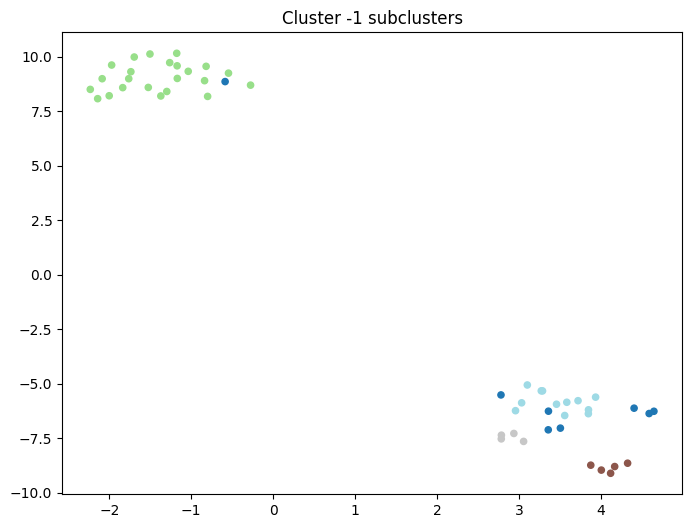


Processing Cluster 1 (336 cases)


Batches: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


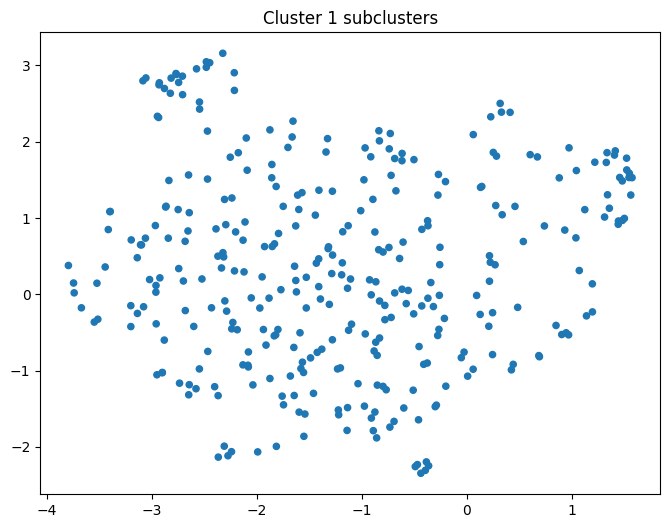


Processing Cluster 5 (86 cases)


Batches: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

  Subcluster 0: 6 cases | Top words: mr, applicant, sentence, jurisdiction, offender, child, said, communications, defendant, sentencing
  Subcluster 1: 3 cases | Top words: para, night, activity, sex, don, old, motive, conversation, friends, police


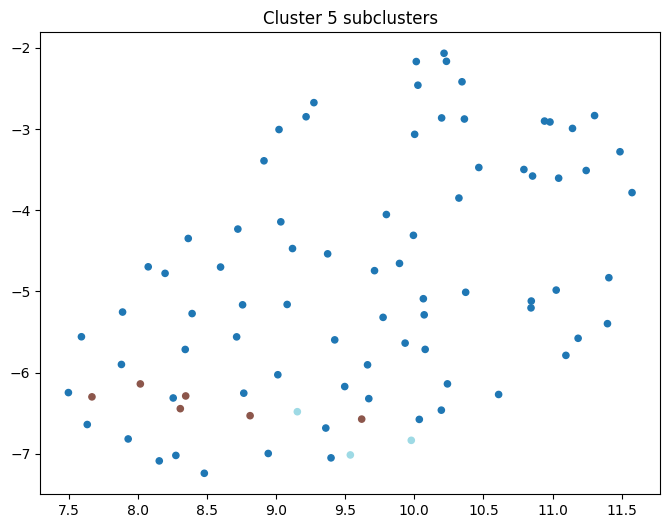


Sub-clustering complete! Selected clusters now have subcluster labels and top keywords.


In [30]:
# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight & fast

# Only sub-cluster these main clusters
clusters_to_process = [-1, 1, 5]

# Dictionary to store subcluster labels and top words
subcluster_results = {}
subcluster_keywords = {}

# Function to get top TF-IDF words for a list of texts
def get_top_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_sums = X.sum(axis=0).A1
    top_indices = tfidf_sums.argsort()[::-1][:top_n]
    return feature_names[top_indices]

# Loop through selected clusters and sub-cluster
for cluster in clusters_to_process:
    cluster_mask = df['Cluster'] == cluster
    cluster_texts = [text for text, mask in zip(texts, cluster_mask) if mask]
    
    if len(cluster_texts) == 0:
        continue
    
    print(f"\nProcessing Cluster {cluster} ({len(cluster_texts)} cases)")
    
    # Generate embeddings
    embeddings = model.encode(cluster_texts, show_progress_bar=True)
    
    # HDBSCAN sub-clustering
    subclusterer = hdbscan.HDBSCAN(
        min_cluster_size=3, 
        metric='euclidean', 
        cluster_selection_method='eom'
    )
    subcluster_labels = subclusterer.fit_predict(embeddings)
    
    # Store subcluster labels
    subcluster_results[cluster] = subcluster_labels
    
    # Store top keywords per subcluster
    subcluster_keywords[cluster] = {}
    unique_subclusters = np.unique(subcluster_labels)
    
    for sc in unique_subclusters:
        if sc == -1:
            continue  # skip noise
        sc_texts = [text for text, lbl in zip(cluster_texts, subcluster_labels) if lbl == sc]
        top_words = get_top_keywords(sc_texts, top_n=10)
        subcluster_keywords[cluster][sc] = top_words
        print(f"  Subcluster {sc}: {len(sc_texts)} cases | Top words: {', '.join(top_words)}")
    
    # Optional: UMAP visualization
    umap_embeddings = umap.UMAP(
        n_neighbors=15, 
        n_components=2, 
        metric='cosine'
    ).fit_transform(embeddings)
    
    plt.figure(figsize=(8,6))
    plt.scatter(
        umap_embeddings[:,0], 
        umap_embeddings[:,1], 
        c=subcluster_labels, 
        cmap='tab20', 
        s=20
    )
    plt.title(f"Cluster {cluster} subclusters")
    plt.show()

# Add subcluster labels to df
for cluster, labels in subcluster_results.items():
    mask = df['Cluster'] == cluster
    df.loc[mask, f'Subcluster_{cluster}'] = labels

print("\nSub-clustering complete! Selected clusters now have subcluster labels and top keywords.")



In [31]:
#print the top keywords per sub-cluster

print("Top keywords per subcluster:\n")

for cluster in subcluster_keywords:
    print(f"Main Cluster {cluster}:")
    for sc, words in subcluster_keywords[cluster].items():
        print(f"  Subcluster {sc} ({len([text for text, lbl in zip(texts, df['Cluster']) if lbl == cluster])} cases): {', '.join(words)}")
    print()


Top keywords per subcluster:

Main Cluster -1:
  Subcluster 0 (52 cases): defendant, sentence, ms, officer, offender, charter, breath, vehicle, para, allen
  Subcluster 1 (52 cases): defendant, complainant, sentence, ms, mr, accused, para, incident, offender, sentencing
  Subcluster 2 (52 cases): ms, complainant, force, website, fear, threatening, children, time, stated, mr
  Subcluster 3 (52 cases): mr, sentence, ms, defendant, offender, messages, delay, records, consent, doubt

Main Cluster 1:

Main Cluster 5:
  Subcluster 0 (86 cases): mr, applicant, sentence, jurisdiction, offender, child, said, communications, defendant, sentencing
  Subcluster 1 (86 cases): para, night, activity, sex, don, old, motive, conversation, friends, police



**Sub-Cluster Analysis**

- Cluster -1:
    * Subcluster 0: Likely procedural or traffic/Charter-related cases, including vehicle offenses, driving under influence, or other legal procedural matters.
     * Subcluster 1: Probably general criminal cases, possibly minor assaults, property crimes, or mixed offenses; broadly procedural with no strong thematic signal.
     * Subcluster 2: Likely sexual offenses or threats, some involving minors, possibly online/technology-facilitated offenses.
     * Subcluster 3: ikely assault or sexual consent-related cases, procedural context emphasized (delay, records, consent), overlaps with sexual/offense context.

- Cluster 5:
    * Subcluster 0: Likely child-related general criminal cases, maybe minor abuse or family-related criminal offenses. Procedural and sentencing context is strong.
     * Subcluster 1:Likely sexual offenses in social contexts, possibly assaults at parties or social gatherings, involving victims and witnesses.


In [32]:
df.head()

,Judge,Heard_Date,Released_Date,Case_Title,URL,Cluster,Subcluster_-1,Subcluster_1,Subcluster_5
0,C.A. Brannagan,27 November 2025,2025-12-31,R. v. M.T.,https://www.canlii.org/en/on/oncj/doc/2025/202...,4,NaN,NaN,NaN
1,Fergus ODonnell,Unknown,2025-12-30,R. v. J.G.,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN
2,S. Robichaud,"October 27 to October 31, November 12, 17-25, ...",2025-12-29,R. v. Laguerre,https://www.canlii.org/en/on/oncj/doc/2025/202...,4,NaN,NaN,NaN
3,S. Robichaud,"December 29, 2025",2025-12-29,R. v. Khosa,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN
4,S. G. Pratt,"4 November, 17 December, 2025",2025-12-24,R. v. Lachance,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN


### Complexity Analysis Per Topic

In [ ]:
#import libraries 
from collections import defaultdict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat


# Define lexicons for complexity analysis
POSITIVE_LEXICON = {
    'allowed': 3, 'granted': 3, 'admissible': 4, 'proper': 2, 'reasonable': 2,
    'appropriate': 2, 'valid': 3, 'legitimate': 3, 'complies': 2, 'satisfied': 2,
    'accepted': 2, 'approved': 3, 'successful': 3, 'favorable': 3, 'supported': 2,
    'credible': 3, 'reliable': 2, 'clear': 1, 'accurate': 2, 'adequate': 2,
    'justified': 3, 'lawful': 3, 'sound': 2, 'consistent': 2, 'persuasive': 2,
}

NEGATIVE_LEXICON = {
    'dismissed': -4, 'denied': -4, 'rejected': -4, 'inadmissible': -4,
    'prejudice': -3, 'improper': -3, 'violation': -4, 'breach': -4,
    'failed': -3, 'contravenes': -4, 'insufficient': -3, 'flawed': -3,
    'unreliable': -3, 'questionable': -2, 'doubtful': -2, 'inconsistent': -2,
    'unreasonable': -3, 'inadequate': -2, 'deficient': -2, 'unacceptable': -3,
}

CONVERSION_WORDS = {
    'however', 'whereas', 'notwithstanding', 'nevertheless', 'nonetheless',
    'although', 'though', 'despite', 'conversely', 'contrary',
    'moreover', 'furthermore', 'additionally', 'accordingly', 'consequently',
    'therefore', 'thus', 'hence', 'subsequently', 'alternatively',
    'similarly', 'likewise', 'whilst',
}

LEGAL_STOPWORDS = {'court', 'section', 'subsection', 'shall', 'may', 'pursuant', 'case'}
ALL_STOPWORDS = set(ENGLISH_STOP_WORDS).union(LEGAL_STOPWORDS)

# VADER analyzer
analyzer = SentimentIntensityAnalyzer()
print("✓ Lexicons and stopwords loaded")

✓ Lexicons and stopwords loaded
Cluster 4 — Processing case 1/8
Cluster 4 — Processing case 2/8
Cluster 4 — Processing case 3/8
Cluster 4 — Processing case 4/8
Cluster 4 — Processing case 5/8
Cluster 4 — Processing case 6/8
Cluster 4 — Processing case 7/8
Cluster 4 — Processing case 8/8
Cluster 1 — Processing case 1/336
Cluster 1 — Processing case 2/336
Cluster 1 — Processing case 3/336
Cluster 1 — Processing case 4/336
Cluster 1 — Processing case 5/336
Cluster 1 — Processing case 6/336
Cluster 1 — Processing case 7/336
Cluster 1 — Processing case 8/336
Cluster 1 — Processing case 9/336
Cluster 1 — Processing case 10/336
Cluster 1 — Processing case 11/336
Cluster 1 — Processing case 12/336
Cluster 1 — Processing case 13/336
Cluster 1 — Processing case 14/336
Cluster 1 — Processing case 15/336
Cluster 1 — Processing case 16/336
Cluster 1 — Processing case 17/336
Cluster 1 — Processing case 18/336
Cluster 1 — Processing case 19/336
Cluster 1 — Processing case 20/336
Cluster 1 — Processin

In [ ]:
# Metrics / helper functions
def tokenize(text):
    return re.findall(r'\b[a-z]+\b', str(text).lower())

def calculate_sentiment(tokens):
    pos_score = sum(POSITIVE_LEXICON.get(t, 0) for t in tokens)
    neg_score = sum(NEGATIVE_LEXICON.get(t, 0) for t in tokens)
    total_score = (pos_score + neg_score) / len(tokens) if tokens else 0
    sentiment_class = 'Positive' if total_score > 0.005 else ('Negative' if total_score < -0.005 else 'Neutral')
    return total_score, sentiment_class

def count_citations(text):
    patterns = [
        r'\bR\.\s+v\.\s+[A-Z]', r'\bs\.\s*\d+', r'\bss\.\s*\d+',
        r'\bsection\s+\d+', r'\d+\(\d+\)', r'Criminal\s+Code',
        r'\[\d{4}\]', r'\d+\s+S\.C\.R\.', r'para\.\s*\d+',
    ]
    return sum(len(re.findall(p, str(text), re.IGNORECASE)) for p in patterns)

def count_conversion_words(tokens):
    return sum(1 for t in tokens if t in CONVERSION_WORDS)

def classify_complexity(score):
    if score >= 0.040: return 'Very High'
    elif score >= 0.030: return 'High'
    elif score >= 0.020: return 'Medium'
    elif score >= 0.010: return 'Low'
    else: return 'Very Low'

def analyze_text(text):
    tokens = [t for t in tokenize(text) if t not in ALL_STOPWORDS and len(t) > 2]

    citations = count_citations(text)
    conversions = count_conversion_words(tokens)
    avg_sentence_length = len(tokens) / max(1, len(re.findall(r'[.!?]+', text)))
    readability = textstat.gunning_fog(text)
    complexity_score = (citations + conversions) / len(tokens) if tokens else 0
    sentiment_score, sentiment_class = calculate_sentiment(tokens)

    return {
        'word_count': len(tokens),
        'sentence_count': len(re.findall(r'[.!?]+', text)),
        'citation_count': citations,
        'conversion_word_count': conversions,
        'readability': readability,
        'avg_sentence_length': avg_sentence_length,
        'complexity_score': complexity_score,
        'sentiment_score': sentiment_score,
        'sentiment_class': sentiment_class
    }



In [ ]:
# Per-Cluster analysis
cluster_results = defaultdict(list)

for cluster in df['Cluster'].unique():
    cluster_texts = [text for text, lbl in zip(texts, df['Cluster']) if lbl == cluster]
    for idx, text in enumerate(cluster_texts, 1):
        print(f"Cluster {cluster} — Processing case {idx}/{len(cluster_texts)}")
        cluster_results[cluster].append(analyze_text(text))

# Aggregate per cluster
cluster_summary = {}
for cluster, metrics_list in cluster_results.items():
    df_metrics = pd.DataFrame(metrics_list)
    numeric_df = df_metrics.select_dtypes(include='number')  
    cluster_summary[cluster] = numeric_df.mean()

cluster_summary_df = pd.DataFrame(cluster_summary).T
cluster_summary_df['complexity_category'] = cluster_summary_df['complexity_score'].apply(classify_complexity)

print("\nCluster-level complexity summary:")
print(cluster_summary_df)

In [44]:
cluster_summary_df

,word_count,sentence_count,citation_count,conversion_word_count,readability,avg_sentence_length,complexity_score,sentiment_score,complexity_category
4,5032.875000,1073.625000,60.250000,10.000000,12.327201,4.427065,0.018522,0.012107,Low
1,2515.529762,461.958333,49.973214,6.300595,12.666440,5.694178,0.022130,0.011069,Medium
5,2834.302326,666.058140,51.046512,6.732558,12.192402,4.690844,0.022606,0.007550,Medium
-1,2512.711538,509.673077,57.346154,5.942308,12.121142,4.981383,0.024104,0.007777,Medium
2,2267.750000,424.916667,69.500000,4.250000,13.177644,5.490660,0.037864,0.008081,High
0,221.000000,28.285714,3.000000,0.000000,14.619710,7.895238,0.013575,0.009050,Low
3,3181.888889,665.111111,59.777778,7.666667,12.063455,4.923011,0.024234,0.011394,Medium


- Cluster 4 contains the largest text volume on average (~5,000 words) with a high number of sentences (~1,074), yet its complexity score is relatively low (0.0185, Low), indicating that despite length, the language is easier to follow, with fewer citations and conversion words proportionally.

- Clusters 1, 5, and -1 all have moderate word counts (~2,500–2,800) and a similar number of citations and conversion words, resulting in Medium complexity scores (~0.022–0.024). Their average sentence lengths (~4.7–5.7 words per sentence) and readability scores (~12.1–12.7) suggest standard legal language that is denser than Cluster 4 but still manageable.

- Cluster 2 stands out as the most complex (High, 0.0379), with slightly fewer words than Clusters 1/5 but a higher citation count (~70) and slightly longer sentences (~5.5 words per sentence). This cluster likely contains more legal references and linking words, making the text denser and harder to read.

- Cluster 0 is much shorter (~221 words) as those are the cases that have not been resolved, thus all contain the same plain text

Overall, clusters with higher citation density and conversion words tend to increase the complexity score, while longer clusters with simpler sentence structure may appear less complex despite higher word counts. Sentiment scores remain low across clusters, indicating largely neutral language.

### Duration Calculation

In [45]:
# Calculate duration from dates
print("="*80)
print("CALCULATING DURATION")
print("="*80)

def parse_date(date_str):
    if pd.isna(date_str): return None
    for fmt in ['%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y', '%Y/%m/%d', '%B %d, %Y', '%b %d, %Y']:
        try: return pd.to_datetime(date_str, format=fmt)
        except: continue
    try: return pd.to_datetime(date_str)
    except: return None

df['heard_date_parsed'] = df['Heard_Date'].apply(parse_date)
df['released_date_parsed'] = df['Released_Date'].apply(parse_date)
df['duration'] = (df['released_date_parsed'] - df['heard_date_parsed']).dt.days

# Remove negative durations
negative_count = (df['duration'] < 0).sum()
if negative_count > 0:
    print(f"Removing {negative_count} cases with negative duration")
    df.loc[df['duration'] < 0, 'duration'] = np.nan

print(f"\n✓ Duration calculated for {df['duration'].notna().sum()} cases")
print(f"\nDuration statistics:")
print(df['duration'].describe())

CALCULATING DURATION
Removing 7 cases with negative duration

✓ Duration calculated for 181 cases

Duration statistics:
count     181.000000
mean     1019.613260
std      2157.893702
min         0.000000
25%        12.000000
50%        30.000000
75%       127.000000
max      8771.000000
Name: duration, dtype: float64


OVERALL DURATION STATISTICS

Mean: 1019.6 days
Median: 30.0 days
Range: 0 - 8771 days


NameError: name 'OUTPUT_DIR' is not defined

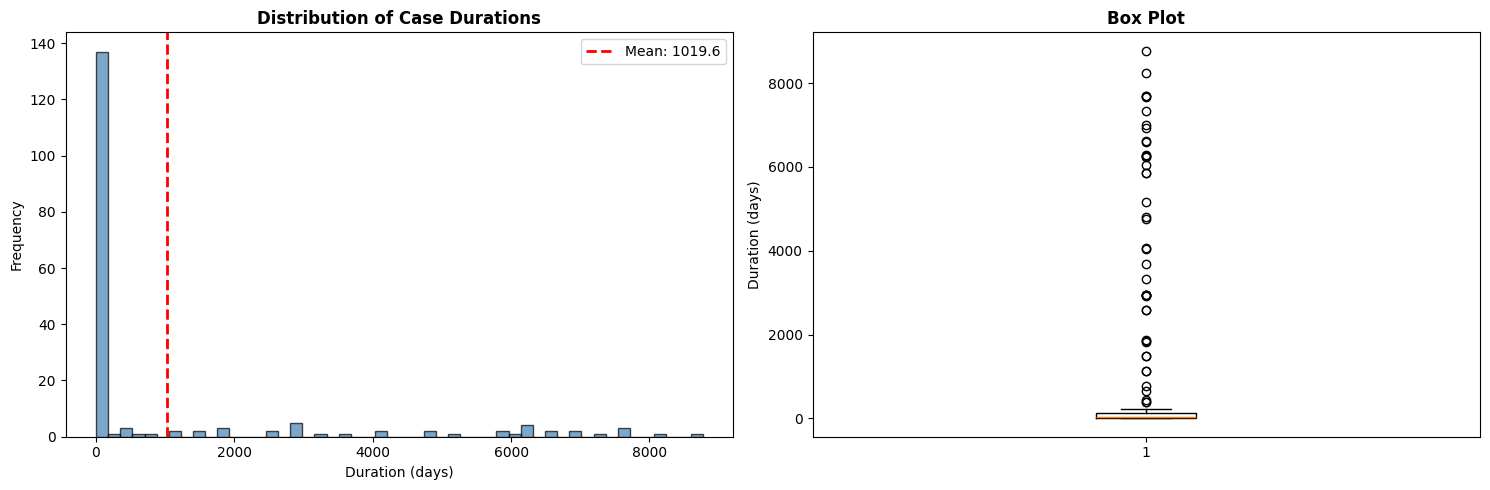

In [46]:
# Overall duration statistics
print("="*80)
print("OVERALL DURATION STATISTICS")
print("="*80)
print(f"\nMean: {df['duration'].mean():.1f} days")
print(f"Median: {df['duration'].median():.1f} days")
print(f"Range: {df['duration'].min():.0f} - {df['duration'].max():.0f} days")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(df['duration'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df['duration'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["duration"].mean():.1f}')
axes[0].set_xlabel('Duration (days)'); axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Case Durations', fontweight='bold'); axes[0].legend()
axes[1].boxplot(df['duration'].dropna())
axes[1].set_ylabel('Duration (days)'); axes[1].set_title('Box Plot', fontweight='bold')
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}01_overall_duration.png', dpi=300, bbox_inches='tight'); plt.show()
print("01_overall_duration.png")

In [47]:
# Duration by Judge
print("\n" + "="*80)
print("DURATION BY JUDGE")
print("="*80)

judge_stats = df.groupby('Judge')['duration'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)
judge_stats_filtered = judge_stats[judge_stats['count'] >= 3].sort_values('mean', ascending=False)

print(f"\n📊 Top 10 Longest:")
print(judge_stats_filtered.head(10))
print(f"\n📊 Top 10 Shortest:")
print(judge_stats_filtered.tail(10))

judge_stats_filtered.to_csv(f'{OUTPUT_DIR}02_duration_by_judge.csv')
print(f"\n✓ Saved: 02_duration_by_judge.csv")


DURATION BY JUDGE

📊 Top 10 Longest:
                     count     mean  median      std   min     max
Judge                                                             
P.T. O’Marra             4  3351.25  3191.5  3797.98  33.0  6989.0
G.P. Renwick            10  2924.50     6.5  3837.90   0.0  8771.0
Christine Mainville      5  2869.80  2931.0  2405.85  23.0  6607.0
André Chamberlain        3  2567.00    17.0  4429.73   2.0  7682.0
Paul F. Monahan          3  2106.00    32.0  3597.47  26.0  6260.0
Seth Weinstein           3  2089.33    17.0  3604.12   0.0  6251.0
J.P.P. Fiorucci          3  2062.67    90.0  3455.80  45.0  6053.0
Unknown                  8  1752.25    19.5  3222.17   0.0  7340.0
G. Jenner                4  1473.25    21.5  2917.22   1.0  5849.0
Brock Jones              8  1333.50    11.5  2762.75   3.0  7691.0

📊 Top 10 Shortest:
                     count    mean  median      std   min     max
Judge                                                            
Davin 

NameError: name 'OUTPUT_DIR' is not defined

In [48]:
# Duration by Cluster (YOUR TEAMMATE'S CLUSTERS!)
print("\n" + "="*80)
print("DURATION BY OFFENSE TYPE (Using Your Teammate's Clusters)")
print("="*80)

df_analysis = df[df['Cluster'] != 0].copy()
cluster_stats = df_analysis.groupby('cluster_name')['duration'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

print(cluster_stats)

cluster_stats.to_csv(f'{OUTPUT_DIR}03_duration_by_offense_type.csv')
print(f"\n✓ Saved: 03_duration_by_offense_type.csv")

# ANOVA test
groups = [group['duration'].dropna().values for name, group in df_analysis.groupby('Cluster')]
f_stat, p_value = stats.f_oneway(*groups)
print(f"\nANOVA: F={f_stat:.4f}, p={p_value:.4f}")
if p_value < 0.05:
    print("✓ SIGNIFICANT differences across offense types")


DURATION BY OFFENSE TYPE (Using Your Teammate's Clusters)


KeyError: 'cluster_name'

In [ ]:
# Duration by Complexity
print("\n" + "="*80)
print("DURATION BY COMPLEXITY")
print("="*80)

complexity_stats = df.groupby('complexity_category')['duration'].agg(['count', 'mean', 'median', 'std']).round(2)
print(complexity_stats)

complexity_stats.to_csv(f'{OUTPUT_DIR}04_duration_by_complexity.csv')
print(f"\n✓ Saved: 04_duration_by_complexity.csv")

# Correlation
valid_data = df[['complexity_score', 'duration']].dropna()
if len(valid_data) > 0:
    corr, p = stats.pearsonr(valid_data['complexity_score'], valid_data['duration'])
    print(f"\nCorrelation: r={corr:.4f}, p={p:.4f}")

In [ ]:
# Combined: Offense Type × Complexity
print("\n" + "="*80)
print("COMBINED ANALYSIS: OFFENSE × COMPLEXITY")
print("="*80)

pivot = df[df['Cluster'] != 0].pivot_table(values='duration', index='cluster_name', 
                                            columns='complexity_category', aggfunc='mean').round(2)
print(pivot)

pivot.to_csv(f'{OUTPUT_DIR}05_duration_offense_complexity_matrix.csv')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Mean Duration (days)'})
plt.title('Duration by Offense Type and Complexity', fontsize=14, fontweight='bold')
plt.xlabel('Complexity'); plt.ylabel('Offense Type')
plt.tight_layout(); plt.savefig(f'{OUTPUT_DIR}05_heatmap.png', dpi=300, bbox_inches='tight'); plt.show()
print("\n✓ Saved: 05_heatmap.png")